## 💻 환경 설정

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
import sys

import geopy
from tqdm import tqdm

from pycaret.regression import *

#경고창이 뜨지 않도록 해주는 것
import warnings
warnings.filterwarnings('ignore')

# notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것
%matplotlib inline 

>주피터 노트북에서 시각화할때, matplotlib가 한글 폰트 지원하지 않아, 깨짐 처리해줘야 함

In [5]:
import platform                

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': #맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':#윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

> pandas 작업 중 tqdm을 사용하기 위해 다음과 같은 설정을 합니다.

In [6]:
tqdm.pandas()

>복원성을 위해 아래 random_state를 상수로 고정합니다.

In [7]:
RANDOM_STATE= 0
np.random.seed(RANDOM_STATE)

##  💻데이터 불러오기 

In [8]:
df = pd.read_csv('./NYC_taxi_extra_info.csv') 

In [9]:
df.head()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lat,lon,temp,humid,pressure,wind_direction,wind_speed,des,wind_x,wind_y,is_raining,is_snowing,is_cloudy,is_clear,weather_strength
0,11106,2015-01-01 00:00:00,1,1,3,0,1,75,40.761229,-73.929593,-5.1,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.93358,0,0,0,1,0
1,10006,2015-01-01 00:00:00,1,1,3,0,1,64,40.708312,-74.013440,-5.1,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.93358,0,0,0,1,0
2,11201,2015-01-01 00:00:00,1,1,3,0,1,169,40.692500,-73.991763,-5.1,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.93358,0,0,0,1,0
3,11430,2015-01-01 00:00:00,1,1,3,0,1,222,40.653199,-73.784133,-5.1,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.93358,0,0,0,1,0
4,10032,2015-01-01 00:00:00,1,1,3,0,1,64,40.837391,-73.941015,-5.1,59.0,1022.0,249.0,2.0,sky_is_clear,-0.358368,-0.93358,0,0,0,1,0


In [10]:
df.shape

(87020, 23)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   zip_code          87020 non-null  int64  
 1   pickup_hour       87020 non-null  object 
 2   month             87020 non-null  int64  
 3   day               87020 non-null  int64  
 4   weekday           87020 non-null  int64  
 5   hour              87020 non-null  int64  
 6   is_weekend        87020 non-null  int64  
 7   cnt               87020 non-null  int64  
 8   lat               87020 non-null  float64
 9   lon               87020 non-null  float64
 10  temp              87020 non-null  float64
 11  humid             87020 non-null  float64
 12  pressure          87020 non-null  float64
 13  wind_direction    87020 non-null  float64
 14  wind_speed        87020 non-null  float64
 15  des               87020 non-null  object 
 16  wind_x            87020 non-null  float6

> 결측치가 하나도 없습니다.

In [13]:
df['weekday_sin']=np.sin(2*np.pi*df.weekday/7)
df['weekday_cos']=np.cos(2*np.pi*df.weekday/7)
df['hour_sin']=np.sin(2*np.pi*df.hour/24)
df['hour_cos']=np.cos(2*np.pi*df.hour/24)

> cycling column을 적절히 처리해줍니다.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   zip_code          87020 non-null  int64  
 1   pickup_hour       87020 non-null  object 
 2   day               87020 non-null  int64  
 3   weekday           87020 non-null  int64  
 4   hour              87020 non-null  int64  
 5   is_weekend        87020 non-null  int64  
 6   cnt               87020 non-null  int64  
 7   lat               87020 non-null  float64
 8   lon               87020 non-null  float64
 9   temp              87020 non-null  float64
 10  humid             87020 non-null  float64
 11  pressure          87020 non-null  float64
 12  wind_speed        87020 non-null  float64
 13  des               87020 non-null  object 
 14  wind_x            87020 non-null  float64
 15  wind_y            87020 non-null  float64
 16  is_raining        87020 non-null  int64 

In [19]:
del df['wind_direction']
del df['month']
del df['weekday']
del df['hour']
del df['pressure']
del df['des']

In [22]:
del df['zip_code']

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pickup_hour       87020 non-null  object 
 1   day               87020 non-null  int64  
 2   is_weekend        87020 non-null  int64  
 3   cnt               87020 non-null  int64  
 4   lat               87020 non-null  float64
 5   lon               87020 non-null  float64
 6   temp              87020 non-null  float64
 7   humid             87020 non-null  float64
 8   wind_speed        87020 non-null  float64
 9   wind_x            87020 non-null  float64
 10  wind_y            87020 non-null  float64
 11  is_raining        87020 non-null  int64  
 12  is_snowing        87020 non-null  int64  
 13  is_cloudy         87020 non-null  int64  
 14  is_clear          87020 non-null  int64  
 15  weather_strength  87020 non-null  int64  
 16  weekday_sin       87020 non-null  float6

In [25]:
reg = setup(data = df, target = 'cnt', 
            numeric_features = ['day', 'weather_strength'],
            categorical_features = ['is_weekend'],
            #ignore_features = cols_to_drop + ['corr_max_label', 'cluster', 'corr_max'],
            fold_strategy ='timeseries',
            fold=5,
            use_gpu = True,
            session_id=RANDOM_STATE, 
           )

,Description,Value
0,session_id,0
1,Target,cnt
2,Original Data,"(87020, 20)"
3,Missing Values,False
4,Numeric Features,13
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(60913, 52)"


In [28]:
compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,24.4225,4519.9222,65.6973,0.9522,0.4860,0.8599,9.3240
dt,Decision Tree Regressor,31.3795,8857.4942,91.9051,0.9062,0.5666,0.7486,0.4260
lightgbm,Light Gradient Boosting Machine,36.3792,5676.6070,75.1122,0.9400,1.0581,3.3040,1.1540
xgboost,Extreme Gradient Boosting,36.7362,5666.1860,74.7881,0.9401,1.1297,4.2056,1.7440
et,Extra Trees Regressor,40.1987,8659.7168,90.0663,0.9084,1.0500,3.9408,9.2040
gbr,Gradient Boosting Regressor,83.2481,24280.0963,155.7788,0.7434,1.6586,9.3425,6.1820
catboost,CatBoost Regressor,138.9622,55027.5102,227.3337,0.4178,2.1801,19.8266,14.5040
knn,K Neighbors Regressor,150.6762,77998.9405,278.1011,0.1746,2.0166,17.3168,0.9500
ada,AdaBoost Regressor,157.8278,59442.5064,243.7200,0.3715,2.2662,21.8626,1.9160
lasso,Lasso Regression,189.3859,88397.8915,297.3007,0.0654,2.6447,32.6051,0.0640


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [29]:
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,34.3399,7967.3548,89.2600,0.9153,0.6386,1.4912
1,27.3116,5550.8426,74.5040,0.9421,0.4998,0.7946
2,21.5552,3457.2477,58.7984,0.9619,0.4611,0.7548
3,19.7948,3094.6483,55.6296,0.9682,0.4330,0.7100
4,19.1111,2529.5176,50.2943,0.9734,0.3977,0.5489
Mean,24.4225,4519.9222,65.6973,0.9522,0.4860,0.8599
SD,5.7367,2003.4960,14.2756,0.0213,0.0833,0.3265


In [ ]:
tuned_rf = tune_model(rf, choose_better=True)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:07:09
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


In [24]:
final_rf = finalize_model(rf)

In [27]:
evaluate_model(final_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

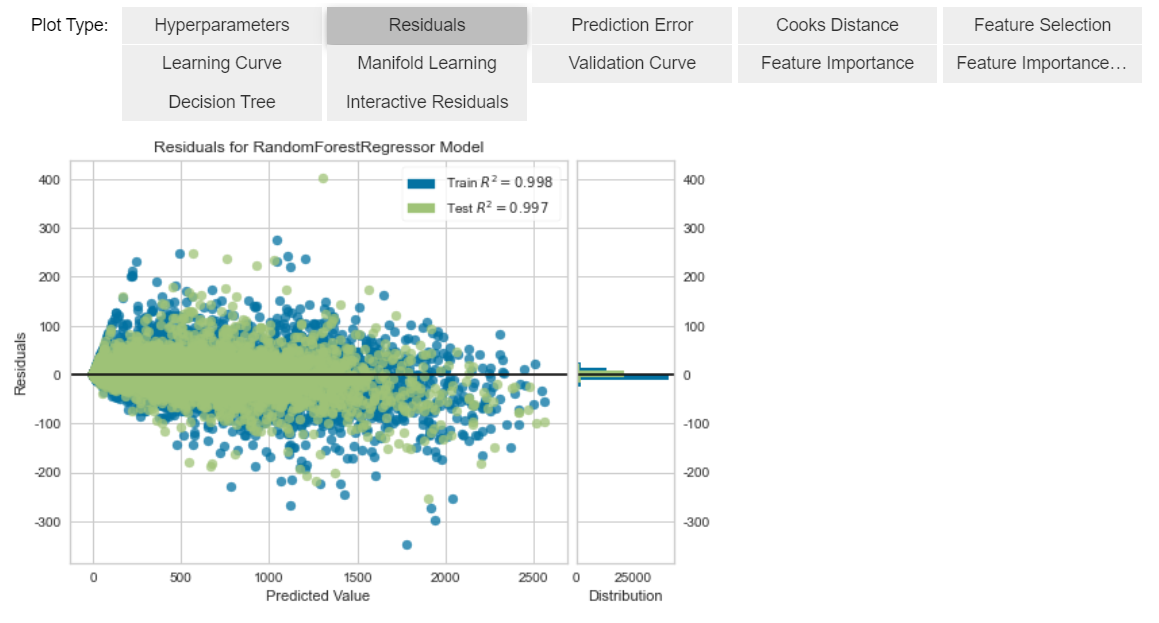

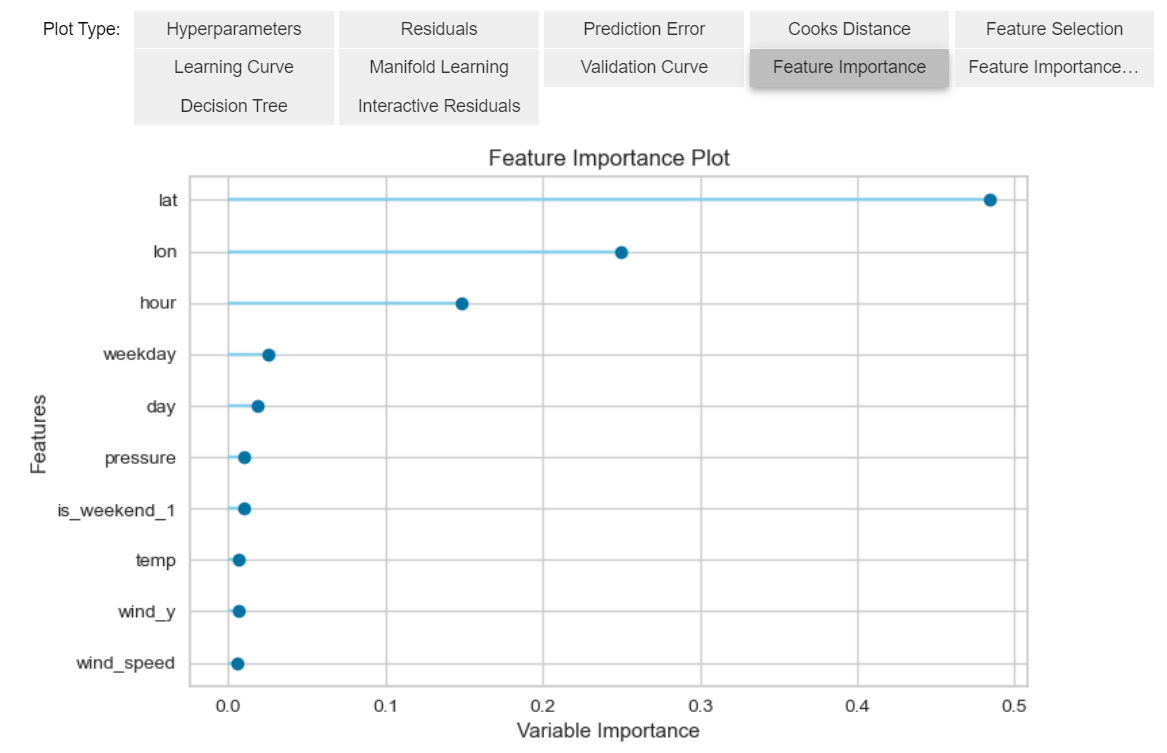